In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymc_marketing import clv
import arviz as az
import pymc as pm
from scipy.stats import beta

In [2]:
orders = pd.read_csv('data/olist/olist_orders_dataset.csv')
payments = pd.read_csv('data/olist/olist_order_payments_dataset.csv')
order_items = pd.read_csv('data/olist/olist_order_items_dataset.csv')
sellers = pd.read_csv('data/olist/olist_sellers_dataset.csv')

In [3]:
order_items_agg = order_items.groupby('order_id').agg(
    seller_id=('seller_id', 'first')
).reset_index()

In [4]:
orders = orders.loc[orders['order_status'] == 'delivered']
orders = orders[["order_id", "order_purchase_timestamp"]]

payments = payments[["order_id", "payment_value"]]
payments = payments.groupby("order_id").sum().reset_index()

In [5]:
merged = pd.merge(orders, payments, on='order_id', how='inner')
merged.order_purchase_timestamp = pd.to_datetime(merged.order_purchase_timestamp)
merged = pd.merge(merged, order_items_agg, on='order_id', how='left')

In [6]:
data = merged.groupby('seller_id').agg(
    monetary_value=('payment_value', 'mean'),
    frequency=('order_id', lambda x: len(x)-1),
    recency = ("order_purchase_timestamp", lambda x: (merged['order_purchase_timestamp'].max() - x.max()).days),
    T = ("order_purchase_timestamp", lambda x: (merged['order_purchase_timestamp'].max() - x.min()).days)
)

array([[<Axes: title={'center': 'monetary_value'}>,
        <Axes: title={'center': 'frequency'}>],
       [<Axes: title={'center': 'recency'}>,
        <Axes: title={'center': 'T'}>]], dtype=object)

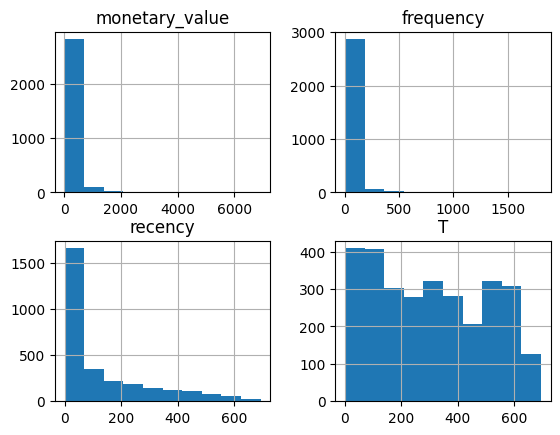

In [7]:
data.hist()

In [8]:
data = data.loc[data.frequency!=0]

In [9]:
data["log_freq"] = np.log(data["frequency"])
data["log_monetary"] = np.log(data["monetary_value"])

array([[<Axes: title={'center': 'log_freq'}>,
        <Axes: title={'center': 'log_monetary'}>]], dtype=object)

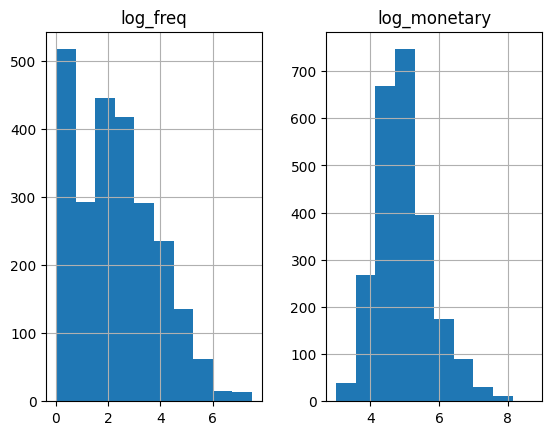

In [10]:
data[["log_freq", "log_monetary"]].hist()

In [11]:
beta_geo_model = clv.BetaGeoModel(
    customer_id=data.index,
    frequency=data["log_freq"],
    recency=data["recency"],
    T=data["T"],
    a_prior=pm.HalfNormal.dist(10),
    b_prior=pm.HalfNormal.dist(10),
    alpha_prior=pm.HalfNormal.dist(10),
    r_prior=pm.HalfNormal.dist(10),
)

In [12]:
beta_geo_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, alpha, r]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Inference data with groups:
	> posterior
	> sample_stats

In [13]:
beta_geo_model.fit_summary()

/home/laurinbrechter/.local/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,22.408,2.499,17.531,26.888,0.086,0.061,825.0,898.0,1.01
b,46.915,5.221,37.845,57.238,0.183,0.130,806.0,1105.0,1.01
alpha,1.445,0.092,1.280,1.630,0.003,0.002,880.0,890.0,1.00
r,0.323,0.010,0.304,0.341,0.000,0.000,947.0,951.0,1.00


Text(0, 0.5, 'pdf')

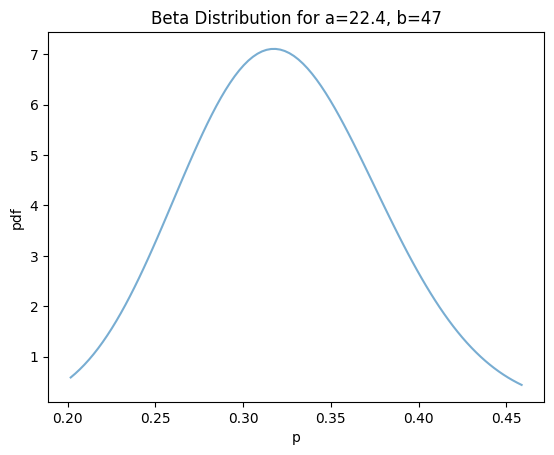

In [14]:
a, b = 22.4, 47

x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
fig, ax = plt.subplots(1,1)
ax.plot(x, beta.pdf(x, a, b), alpha=0.6)
ax.set_title('Beta Distribution for a=22.4, b=47')
ax.set_xlabel('p')
ax.set_ylabel('pdf')